In [ ]:
# Energy Forecasting - Vinergy (II)

In [ ]:
from google.colab import drive ;
drive.mount('/content/drive') ;

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading essential libraries

In [ ]:
import numpy as np ;
import pandas as pd ;
import seaborn as sb ;
import datetime as dt ;
import matplotlib.pyplot as plt ;
import tensorflow as tf ;
from keras import models, layers ;
from sklearn.model_selection import GridSearchCV ;
from sklearn.preprocessing import FunctionTransformer ;
from sklearn.metrics import mean_absolute_error, r2_score ;

In [ ]:
energy = pd.read_csv('/content/drive/MyDrive/Demand Forecasting Demand Data upto Feb 21.csv') ;
energy.head()

,datetime,Demand (MW)
0,1/1/2020 0:00,445.8
1,1/1/2020 1:00,424.5
2,1/1/2020 2:00,423.5
3,1/1/2020 3:00,418.8
4,1/1/2020 4:00,414.8


In [ ]:
def populateWithTimeFeatures(table, dtColumn):
  table.index = pd.to_datetime(table[dtColumn]) ;
  table['Hour'] = table.index.hour ;
  table['Day'] = table.index.day ;
  table['Quarter'] = table.index.quarter ;
  table['Month_Numbered'] = table.index.month ;
  table['Month'] = table.index.month_name() ;
  table['Year'] = table.index.year ;
  table['Week'] = table.index.isocalendar().week ;
  table['Weekday'] = table.index.day_name() ;
  table = table.sort_index() ;
  return table ;

In [ ]:
energy = populateWithTimeFeatures(energy, 'datetime') ;
energy

,datetime,Demand (MW),Hour,Day,Quarter,Month_Numbered,Month,Year,Week,Weekday
datetime,,,,,,,,,,
2020-01-01 00:00:00,1/1/2020 0:00,445.8,0,1,1,1,January,2020,1,Wednesday
2020-01-01 01:00:00,1/1/2020 1:00,424.5,1,1,1,1,January,2020,1,Wednesday
2020-01-01 02:00:00,1/1/2020 2:00,423.5,2,1,1,1,January,2020,1,Wednesday
2020-01-01 03:00:00,1/1/2020 3:00,418.8,3,1,1,1,January,2020,1,Wednesday
2020-01-01 04:00:00,1/1/2020 4:00,414.8,4,1,1,1,January,2020,1,Wednesday
...,...,...,...,...,...,...,...,...,...,...
2023-02-21 19:00:00,2/21/2023 19:00,498.7,19,21,1,2,February,2023,8,Tuesday
2023-02-21 20:00:00,2/21/2023 20:00,498.8,20,21,1,2,February,2023,8,Tuesday
2023-02-21 21:00:00,2/21/2023 21:00,506.4,21,21,1,2,February,2023,8,Tuesday


In [ ]:
weeks = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7} ;
reverse_weeks = {value: key for key, value in weeks.items()} ;
weeks

{'Monday': 1,
 'Tuesday': 2,
 'Wednesday': 3,
 'Thursday': 4,
 'Friday': 5,
 'Saturday': 6,
 'Sunday': 7}

In [ ]:
energy = energy.drop_duplicates() ;
energy

,datetime,Demand (MW),Hour,Day,Quarter,Month_Numbered,Month,Year,Week,Weekday
datetime,,,,,,,,,,
2020-01-01 00:00:00,1/1/2020 0:00,445.8,0,1,1,1,January,2020,1,Wednesday
2020-01-01 01:00:00,1/1/2020 1:00,424.5,1,1,1,1,January,2020,1,Wednesday
2020-01-01 02:00:00,1/1/2020 2:00,423.5,2,1,1,1,January,2020,1,Wednesday
2020-01-01 03:00:00,1/1/2020 3:00,418.8,3,1,1,1,January,2020,1,Wednesday
2020-01-01 04:00:00,1/1/2020 4:00,414.8,4,1,1,1,January,2020,1,Wednesday
...,...,...,...,...,...,...,...,...,...,...
2023-02-21 19:00:00,2/21/2023 19:00,498.7,19,21,1,2,February,2023,8,Tuesday
2023-02-21 20:00:00,2/21/2023 20:00,498.8,20,21,1,2,February,2023,8,Tuesday
2023-02-21 21:00:00,2/21/2023 21:00,506.4,21,21,1,2,February,2023,8,Tuesday


In [ ]:
energy['Weekday_Numbered'] = energy['Weekday'].map(weeks) ;
energy = energy.drop('datetime', axis=1) ;
energy

,Demand (MW),Hour,Day,Quarter,Month_Numbered,Month,Year,Week,Weekday,Weekday_Numbered
datetime,,,,,,,,,,
2020-01-01 00:00:00,445.8,0,1,1,1,January,2020,1,Wednesday,3
2020-01-01 01:00:00,424.5,1,1,1,1,January,2020,1,Wednesday,3
2020-01-01 02:00:00,423.5,2,1,1,1,January,2020,1,Wednesday,3
2020-01-01 03:00:00,418.8,3,1,1,1,January,2020,1,Wednesday,3
2020-01-01 04:00:00,414.8,4,1,1,1,January,2020,1,Wednesday,3
...,...,...,...,...,...,...,...,...,...,...
2023-02-21 19:00:00,498.7,19,21,1,2,February,2023,8,Tuesday,2
2023-02-21 20:00:00,498.8,20,21,1,2,February,2023,8,Tuesday,2
2023-02-21 21:00:00,506.4,21,21,1,2,February,2023,8,Tuesday,2


In [ ]:
weather = pd.read_csv('/content/drive/MyDrive/Demand Forecasting Weather Data upto Feb 28.csv') ;
weather

,Name,datetime,Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,preciptype,snow,...,visibility,solarradiation,uvindex,severerisk,conditions,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,Pokhara,1/1/2020 0:00,38.0,34.4,29.0,69.76,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
1,Pokhara,1/1/2020 1:00,38.0,34.4,29.9,72.37,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
2,Pokhara,1/1/2020 2:00,38.0,35.7,30.8,75.06,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
3,Pokhara,1/1/2020 3:00,37.1,33.4,29.9,74.97,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Partially cloudy,NaN,NaN,NaN,NaN,NaN
4,Pokhara,1/1/2020 4:00,35.1,32.3,29.0,78.41,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Clear,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27715,Pokhara,2/28/2023 19:00,56.0,56.0,39.8,54.45,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN
27716,Pokhara,2/28/2023 20:00,52.1,52.1,41.0,65.83,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN
27717,Pokhara,2/28/2023 21:00,53.1,53.1,41.0,63.45,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN
27718,Pokhara,2/28/2023 22:00,55.1,55.1,41.0,58.85,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN


In [ ]:
weather.index = pd.to_datetime(weather['datetime']) ;
weather = weather.sort_index() ;
weather

,Name,datetime,Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,preciptype,snow,...,visibility,solarradiation,uvindex,severerisk,conditions,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,Pokhara,1/1/2020 0:00,38.0,34.4,29.0,69.76,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,Pokhara,1/1/2020 1:00,38.0,34.4,29.9,72.37,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00:00,Pokhara,1/1/2020 2:00,38.0,35.7,30.8,75.06,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
2020-01-01 03:00:00,Pokhara,1/1/2020 3:00,37.1,33.4,29.9,74.97,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Partially cloudy,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,Pokhara,1/1/2020 4:00,35.1,32.3,29.0,78.41,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Clear,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 19:00:00,Pokhara,2/28/2023 19:00,56.0,56.0,39.8,54.45,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN
2023-02-28 20:00:00,Pokhara,2/28/2023 20:00,52.1,52.1,41.0,65.83,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN
2023-02-28 21:00:00,Pokhara,2/28/2023 21:00,53.1,53.1,41.0,63.45,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN


In [ ]:
weather.isnull().sum()

Name                    0
datetime                0
Temperature             0
feelslike               0
dewpoint                0
humidity                0
precipitation           0
precipprob              0
preciptype          24969
snow                   18
snowdepth              18
windgust            15497
windspeed               0
winddirection           0
sealevelpressure       18
cloudcover              0
visibility             18
solarradiation          0
uvindex                 0
severerisk          17766
conditions              0
Unnamed: 21         27720
Unnamed: 22         27720
Unnamed: 23         27720
Unnamed: 24         27720
Unnamed: 25         27719
dtype: int64

In [ ]:
weather = weather.drop_duplicates() ;
weather

,Name,datetime,Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,preciptype,snow,...,visibility,solarradiation,uvindex,severerisk,conditions,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,Pokhara,1/1/2020 0:00,38.0,34.4,29.0,69.76,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,Pokhara,1/1/2020 1:00,38.0,34.4,29.9,72.37,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00:00,Pokhara,1/1/2020 2:00,38.0,35.7,30.8,75.06,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
2020-01-01 03:00:00,Pokhara,1/1/2020 3:00,37.1,33.4,29.9,74.97,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Partially cloudy,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,Pokhara,1/1/2020 4:00,35.1,32.3,29.0,78.41,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Clear,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 19:00:00,Pokhara,2/28/2023 19:00,56.0,56.0,39.8,54.45,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN
2023-02-28 20:00:00,Pokhara,2/28/2023 20:00,52.1,52.1,41.0,65.83,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN
2023-02-28 21:00:00,Pokhara,2/28/2023 21:00,53.1,53.1,41.0,63.45,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN


Dropping the columns that are massively empty or not relevant !

In [ ]:
weather['severerisk'].unique()

array([ nan,  10.,   3.,   5.,  30.,   8.,  60.,  15.,  75., 100.,  19.,
        25.,  50.,  38.])

In [ ]:
weather['severerisk'] = weather['severerisk'].fillna(1.0) ;
weather.head()

,Name,datetime,Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,preciptype,snow,...,visibility,solarradiation,uvindex,severerisk,conditions,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,Pokhara,1/1/2020 0:00,38.0,34.4,29.0,69.76,0.0,0,NaN,0.0,...,9.9,0.0,0,1.0,Overcast,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,Pokhara,1/1/2020 1:00,38.0,34.4,29.9,72.37,0.0,0,NaN,0.0,...,9.9,0.0,0,1.0,Overcast,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00:00,Pokhara,1/1/2020 2:00,38.0,35.7,30.8,75.06,0.0,0,NaN,0.0,...,9.9,0.0,0,1.0,Overcast,NaN,NaN,NaN,NaN,NaN
2020-01-01 03:00:00,Pokhara,1/1/2020 3:00,37.1,33.4,29.9,74.97,0.0,0,NaN,0.0,...,9.9,0.0,0,1.0,Partially cloudy,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,Pokhara,1/1/2020 4:00,35.1,32.3,29.0,78.41,0.0,0,NaN,0.0,...,9.9,0.0,0,1.0,Clear,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='Temperature', ylabel='severerisk'>

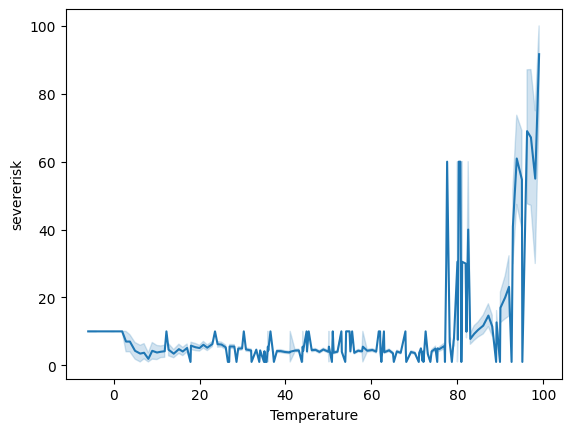

In [ ]:
sb.lineplot(data = weather, x='Temperature', y='severerisk')

In [ ]:
weather_dropped_columns = ['Name', 'datetime', 'preciptype', 'windgust', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25'] ;
weather = weather.drop(weather_dropped_columns, axis=1) ;
weather.head()

,Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,snow,snowdepth,windspeed,winddirection,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,severerisk,conditions
datetime,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,38.0,34.4,29.0,69.76,0.0,0,0.0,0.0,4.7,220.0,1015.4,100.0,9.9,0.0,0,1.0,Overcast
2020-01-01 01:00:00,38.0,34.4,29.9,72.37,0.0,0,0.0,0.0,4.7,230.0,1015.3,100.0,9.9,0.0,0,1.0,Overcast
2020-01-01 02:00:00,38.0,35.7,30.8,75.06,0.0,0,0.0,0.0,3.4,230.0,1015.4,100.0,9.9,0.0,0,1.0,Overcast
2020-01-01 03:00:00,37.1,33.4,29.9,74.97,0.0,0,0.0,0.0,4.7,220.0,1015.3,88.9,9.9,0.0,0,1.0,Partially cloudy
2020-01-01 04:00:00,35.1,32.3,29.0,78.41,0.0,0,0.0,0.0,3.4,240.0,1015.2,0.0,9.9,0.0,0,1.0,Clear


In [ ]:
weather.isnull().sum()

Temperature          0
feelslike            0
dewpoint             0
humidity             0
precipitation        0
precipprob           0
snow                18
snowdepth           18
windspeed            0
winddirection        0
sealevelpressure    18
cloudcover           0
visibility          18
solarradiation       0
uvindex              0
severerisk           0
conditions           0
dtype: int64

We need to filter the data upto Feb 21 only for training dataset !

In [ ]:
weather = weather[weather.index < "2023-02-22 00:00:00"]
weather

,Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,snow,snowdepth,windspeed,winddirection,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,severerisk,conditions
datetime,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,38.0,34.4,29.0,69.76,0.0,0,0.0,0.0,4.7,220.0,1015.4,100.0,9.9,0.0,0,1.0,Overcast
2020-01-01 01:00:00,38.0,34.4,29.9,72.37,0.0,0,0.0,0.0,4.7,230.0,1015.3,100.0,9.9,0.0,0,1.0,Overcast
2020-01-01 02:00:00,38.0,35.7,30.8,75.06,0.0,0,0.0,0.0,3.4,230.0,1015.4,100.0,9.9,0.0,0,1.0,Overcast
2020-01-01 03:00:00,37.1,33.4,29.9,74.97,0.0,0,0.0,0.0,4.7,220.0,1015.3,88.9,9.9,0.0,0,1.0,Partially cloudy
2020-01-01 04:00:00,35.1,32.3,29.0,78.41,0.0,0,0.0,0.0,3.4,240.0,1015.2,0.0,9.9,0.0,0,1.0,Clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-21 19:00:00,50.0,49.4,29.0,44.19,0.0,0,0.0,0.0,3.4,100.0,1009.1,50.0,9.9,0.0,0,10.0,Partially cloudy
2023-02-21 20:00:00,50.0,49.4,28.1,42.59,0.0,0,0.0,0.0,3.4,110.0,1008.1,88.9,9.9,0.0,0,10.0,Partially cloudy
2023-02-21 21:00:00,53.1,53.1,26.1,34.92,0.0,0,0.0,0.0,5.8,130.0,1007.3,100.0,9.9,0.0,0,10.0,Overcast


Preparing a combined training data

In [ ]:
energy.index.is_unique

True

In [ ]:
weather.index.is_unique

False

In [ ]:
indices = energy.index ;
energy = energy.reset_index(drop=True) ;
weather = weather.reset_index(drop=True) ;

In [ ]:
dataset = pd.concat([energy, weather], axis=1) ;
dataset.index = indices ;
ataset = dataset.sort_index() ;
dataset.head()

,Demand (MW),Hour,Day,Quarter,Month_Numbered,Month,Year,Week,Weekday,Weekday_Numbered,...,snowdepth,windspeed,winddirection,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,severerisk,conditions
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,445.8,0,1,1,1,January,2020,1,Wednesday,3,...,0.0,4.7,220.0,1015.4,100.0,9.9,0.0,0,1.0,Overcast
2020-01-01 01:00:00,424.5,1,1,1,1,January,2020,1,Wednesday,3,...,0.0,4.7,230.0,1015.3,100.0,9.9,0.0,0,1.0,Overcast
2020-01-01 02:00:00,423.5,2,1,1,1,January,2020,1,Wednesday,3,...,0.0,3.4,230.0,1015.4,100.0,9.9,0.0,0,1.0,Overcast
2020-01-01 03:00:00,418.8,3,1,1,1,January,2020,1,Wednesday,3,...,0.0,4.7,220.0,1015.3,88.9,9.9,0.0,0,1.0,Partially cloudy
2020-01-01 04:00:00,414.8,4,1,1,1,January,2020,1,Wednesday,3,...,0.0,3.4,240.0,1015.2,0.0,9.9,0.0,0,1.0,Clear


In [ ]:
dataset['conditions'] = dataset['conditions'].str.split(', ') ;
dataset = dataset.explode('conditions') ;
dataset['conditions'].unique()

array(['Overcast', 'Partially cloudy', 'Clear', 'Rain', 'Snow',
       'Freezing Drizzle/Freezing Rain', 'Ice'], dtype=object)

In [ ]:
dataset = pd.get_dummies(dataset, columns=['conditions'], drop_first=False, dtype='int') ;
dataset = dataset.groupby(level=0).max()
dataset.head()

,Demand (MW),Hour,Day,Quarter,Month_Numbered,Month,Year,Week,Weekday,Weekday_Numbered,...,solarradiation,uvindex,severerisk,conditions_Clear,conditions_Freezing Drizzle/Freezing Rain,conditions_Ice,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,conditions_Snow
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,445.8,0,1,1,1,January,2020,1,Wednesday,3,...,0.0,0,1.0,0,0,0,1,0,0,0
2020-01-01 01:00:00,424.5,1,1,1,1,January,2020,1,Wednesday,3,...,0.0,0,1.0,0,0,0,1,0,0,0
2020-01-01 02:00:00,423.5,2,1,1,1,January,2020,1,Wednesday,3,...,0.0,0,1.0,0,0,0,1,0,0,0
2020-01-01 03:00:00,418.8,3,1,1,1,January,2020,1,Wednesday,3,...,0.0,0,1.0,0,0,0,0,1,0,0
2020-01-01 04:00:00,414.8,4,1,1,1,January,2020,1,Wednesday,3,...,0.0,0,1.0,1,0,0,0,0,0,0


In [ ]:
dataset = dataset.ffill()
dataset.isnull().sum()

Demand (MW)                                  0
Hour                                         0
Day                                          0
Quarter                                      0
Month_Numbered                               0
Month                                        0
Year                                         0
Week                                         0
Weekday                                      0
Weekday_Numbered                             0
Temperature                                  0
feelslike                                    0
dewpoint                                     0
humidity                                     0
precipitation                                0
precipprob                                   0
snow                                         0
snowdepth                                    0
windspeed                                    0
winddirection                                0
sealevelpressure                             0
cloudcover   

- UV Index is 100% correlated with solar radiation so, only one feature can be chosen !
- Similarly, 'Quarter' has high correlation with 'Month' and demand fluctuations in month dictate the predictions better !
- 'Temperature', 'feelslike' and 'dewpoint' are highly correlated so, we use dewpoint and temperature to create a relative humidity (rh) metric.
- 'precipprob' is fully correlated with 'Rain' condition along with 'cloudcover' being fully negatively correlated with 'Clear'
- 'precipprob' is dropped along with 'Clear' as they have lesser correlation with demand itself !

In [ ]:
dataset['rh'] = 100 - 5*(dataset['Temperature'] - dataset['dewpoint']) ;
dropped_columns = ['Temperature', 'dewpoint','Quarter', 'Week', 'Month', 'Weekday', 'uvindex', 'precipprob', 'conditions_Clear'] ;
dataset = dataset.drop(dropped_columns, axis=1) ;
dataset.head()

,Demand (MW),Hour,Day,Month_Numbered,Year,Weekday_Numbered,feelslike,humidity,precipitation,snow,...,visibility,solarradiation,severerisk,conditions_Freezing Drizzle/Freezing Rain,conditions_Ice,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,conditions_Snow,rh
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,445.8,0,1,1,2020,3,34.4,69.76,0.0,0.0,...,9.9,0.0,1.0,0,0,1,0,0,0,55.0
2020-01-01 01:00:00,424.5,1,1,1,2020,3,34.4,72.37,0.0,0.0,...,9.9,0.0,1.0,0,0,1,0,0,0,59.5
2020-01-01 02:00:00,423.5,2,1,1,2020,3,35.7,75.06,0.0,0.0,...,9.9,0.0,1.0,0,0,1,0,0,0,64.0
2020-01-01 03:00:00,418.8,3,1,1,2020,3,33.4,74.97,0.0,0.0,...,9.9,0.0,1.0,0,0,0,1,0,0,64.0
2020-01-01 04:00:00,414.8,4,1,1,2020,3,32.3,78.41,0.0,0.0,...,9.9,0.0,1.0,0,0,0,0,0,0,69.5


In [ ]:
y = dataset['Demand (MW)'] ;
x = dataset.drop(['Demand (MW)', 'humidity'], axis=1) ;

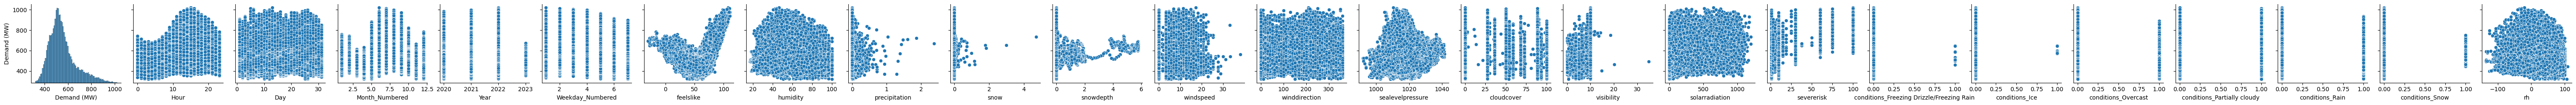

In [ ]:
sb.pairplot(dataset, y_vars='Demand (MW)')

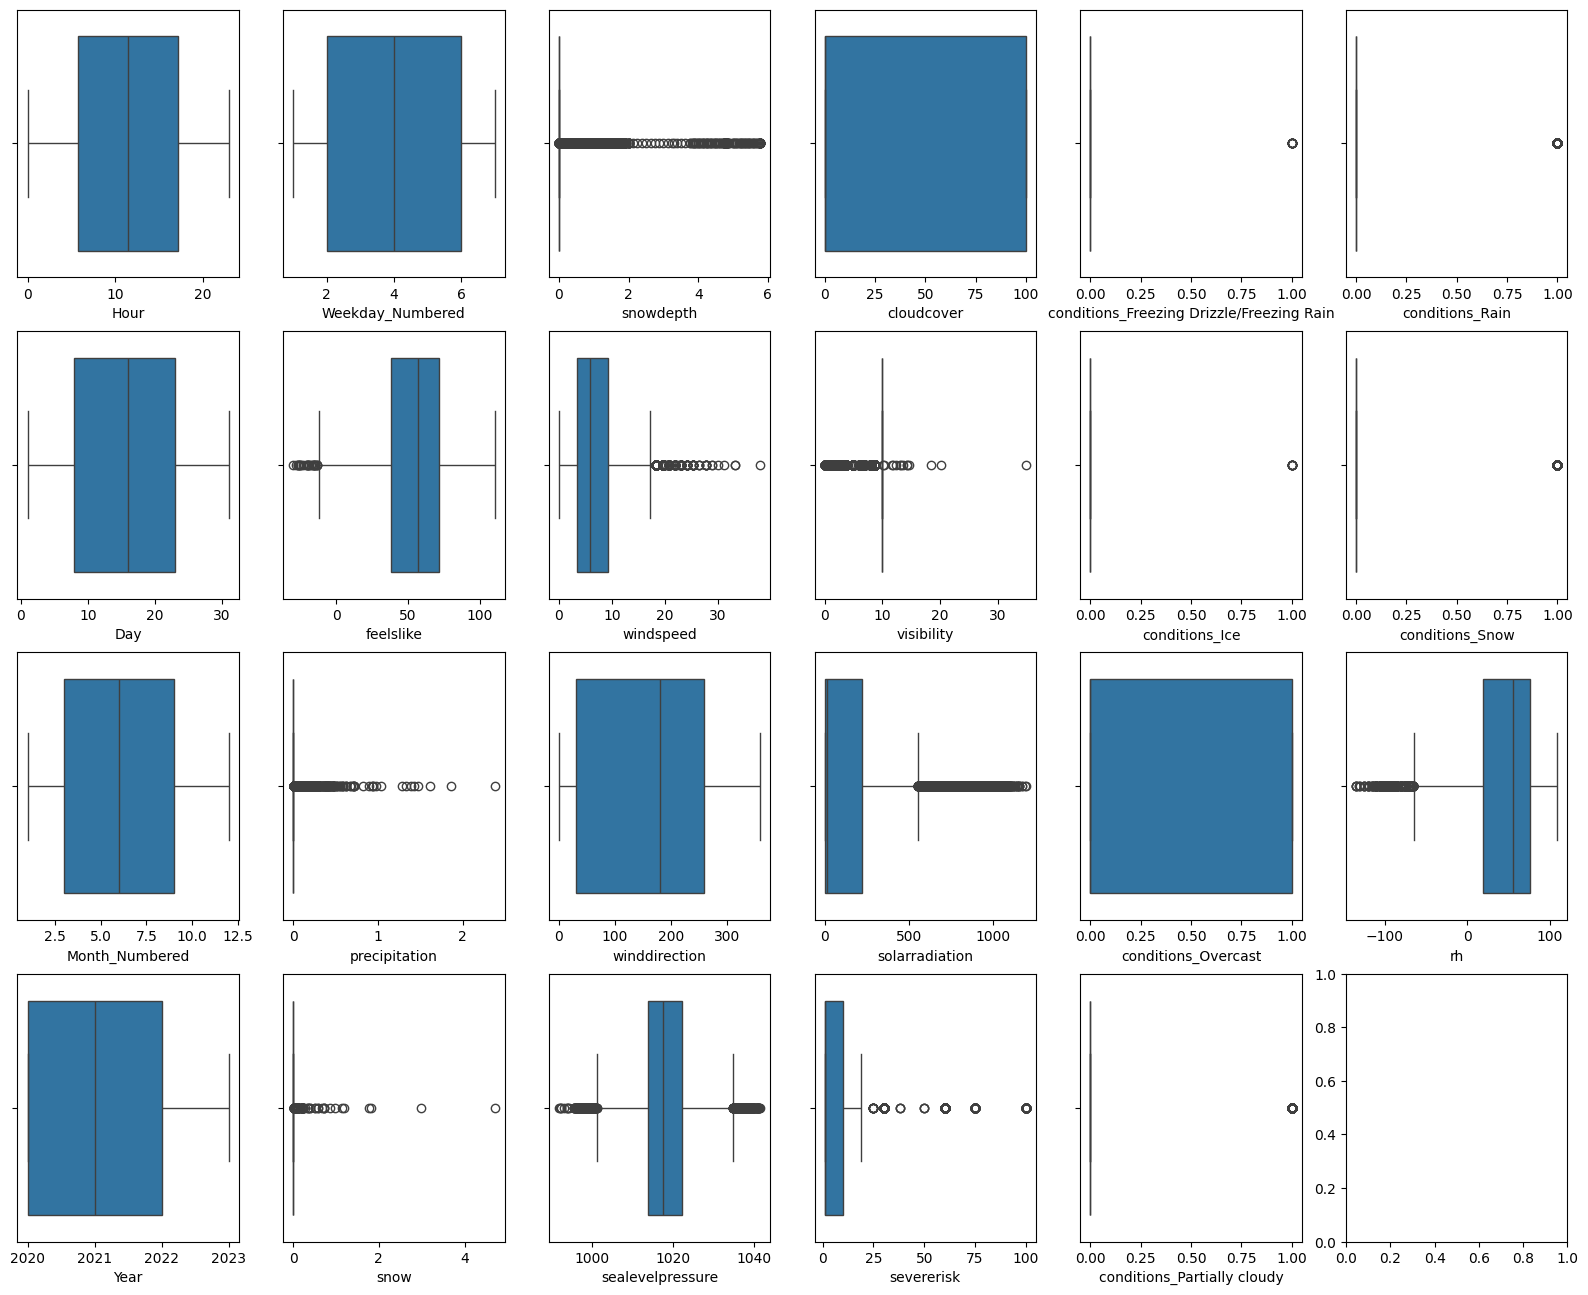

In [ ]:
figure, axes = plt.subplots(4,6, figsize=(20,16)) ;
for i in range(0, len(x.columns)):
    sb.boxplot(data=x, x=x.columns[i], ax=axes[i%4,int(i/4)]) ;

In [ ]:
ft = FunctionTransformer(func=np.log1p) ;
log_needed_features = ['solarradiation', 'severerisk', 'windspeed', 'precipitation', 'snow', 'snowdepth', 'visibility'] ;
for i in log_needed_features:
  x[i] = ft.fit_transform(x[i]) ;

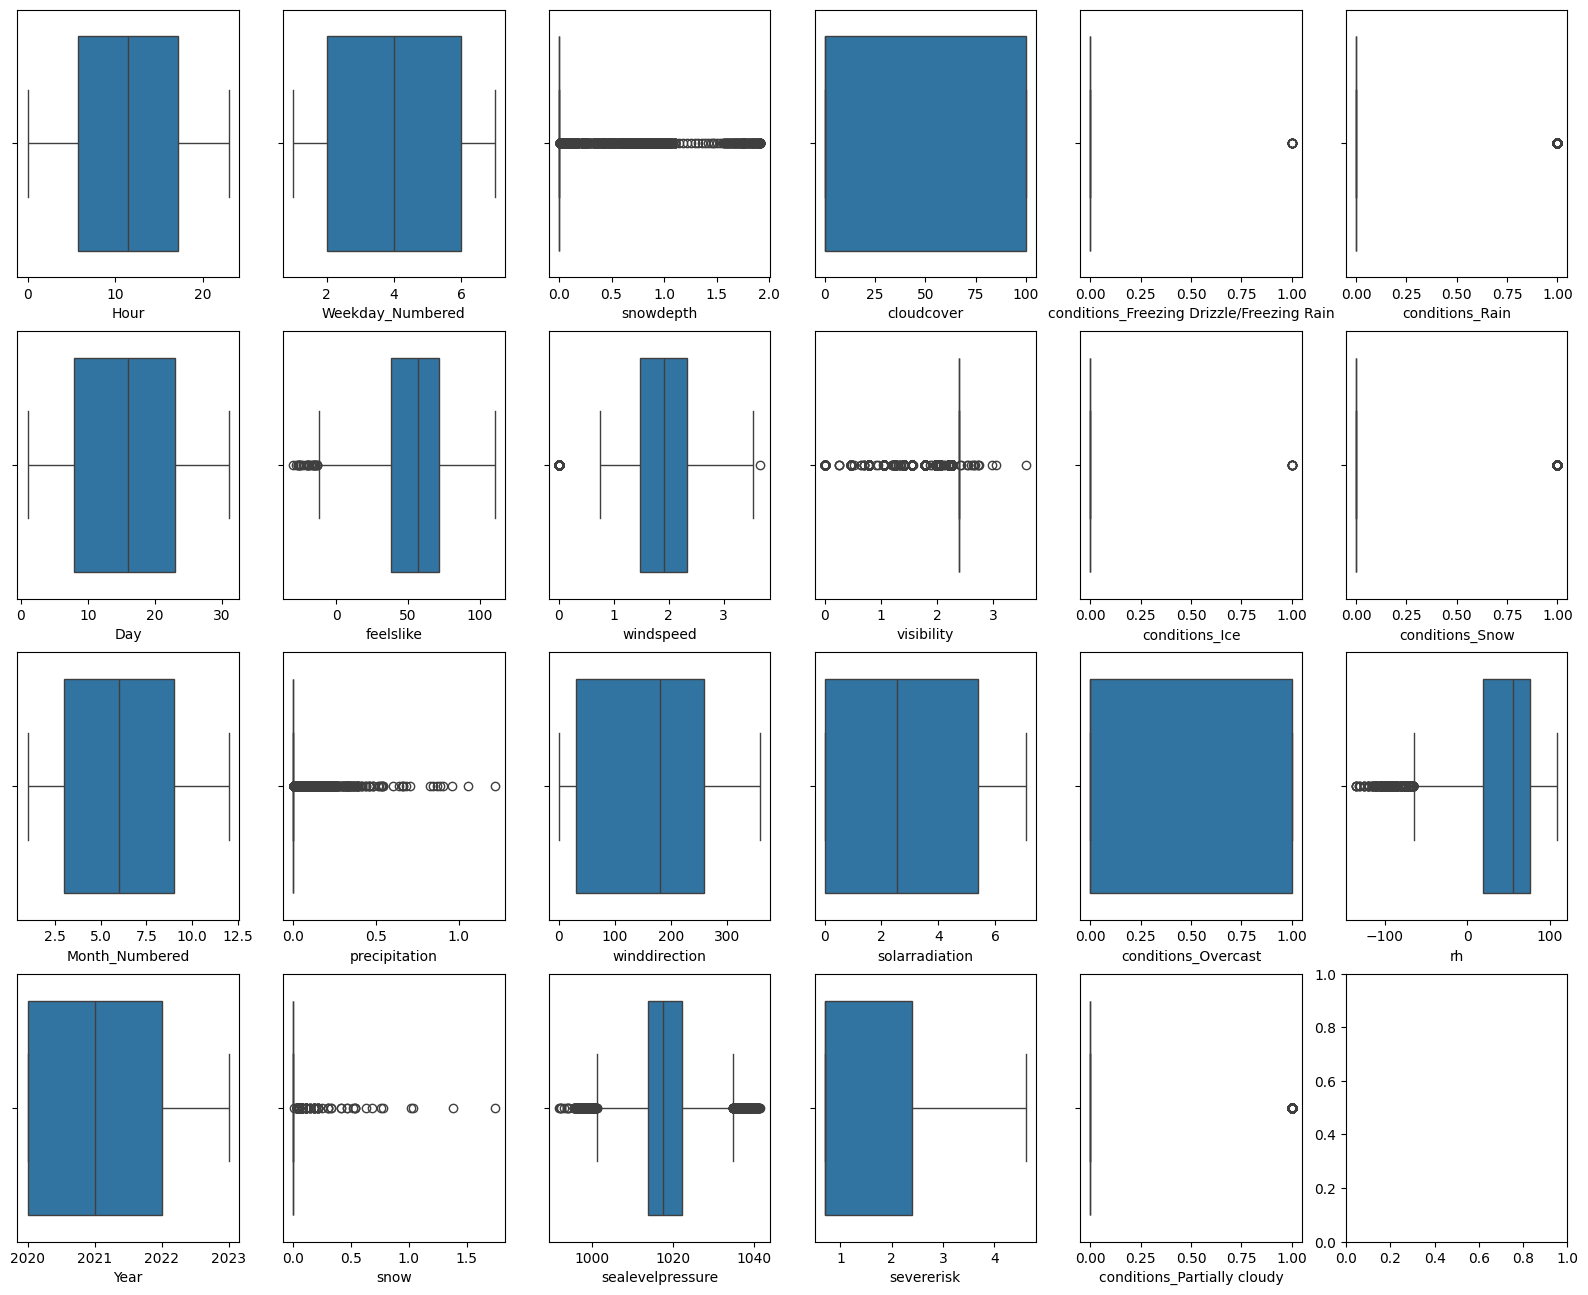

In [ ]:
figure, axes = plt.subplots(4,6, figsize=(20,16)) ;
for i in range(0, len(x.columns)):
    sb.boxplot(data=x, x=x.columns[i], ax=axes[i%4,int(i/4)]) ;

In [ ]:
def generateCaps(df, column):
    q1 = df[column].quantile(0.25) ;
    q3 = df[column].quantile(0.75) ;
    iqr = q3 - q1 ;
    caps = [] ;
    caps.append(q1-(1.5*iqr)) ;
    caps.append(q3+(1.5*iqr)) ;
    return caps ;

In [ ]:
def countOutliers(df, column):
    limits = generateCaps(df, column) ;
    return len(df[df[column] > limits[1]] + len(df[df[column] < limits[0]])) ;

In [ ]:
def capOutliers(df, column):
    limits = generateCaps(df, column) ;
    return np.where(df[column] > limits[1], limits[1],
                   np.where(df[column] < limits[0], limits[0], df[column])) ;

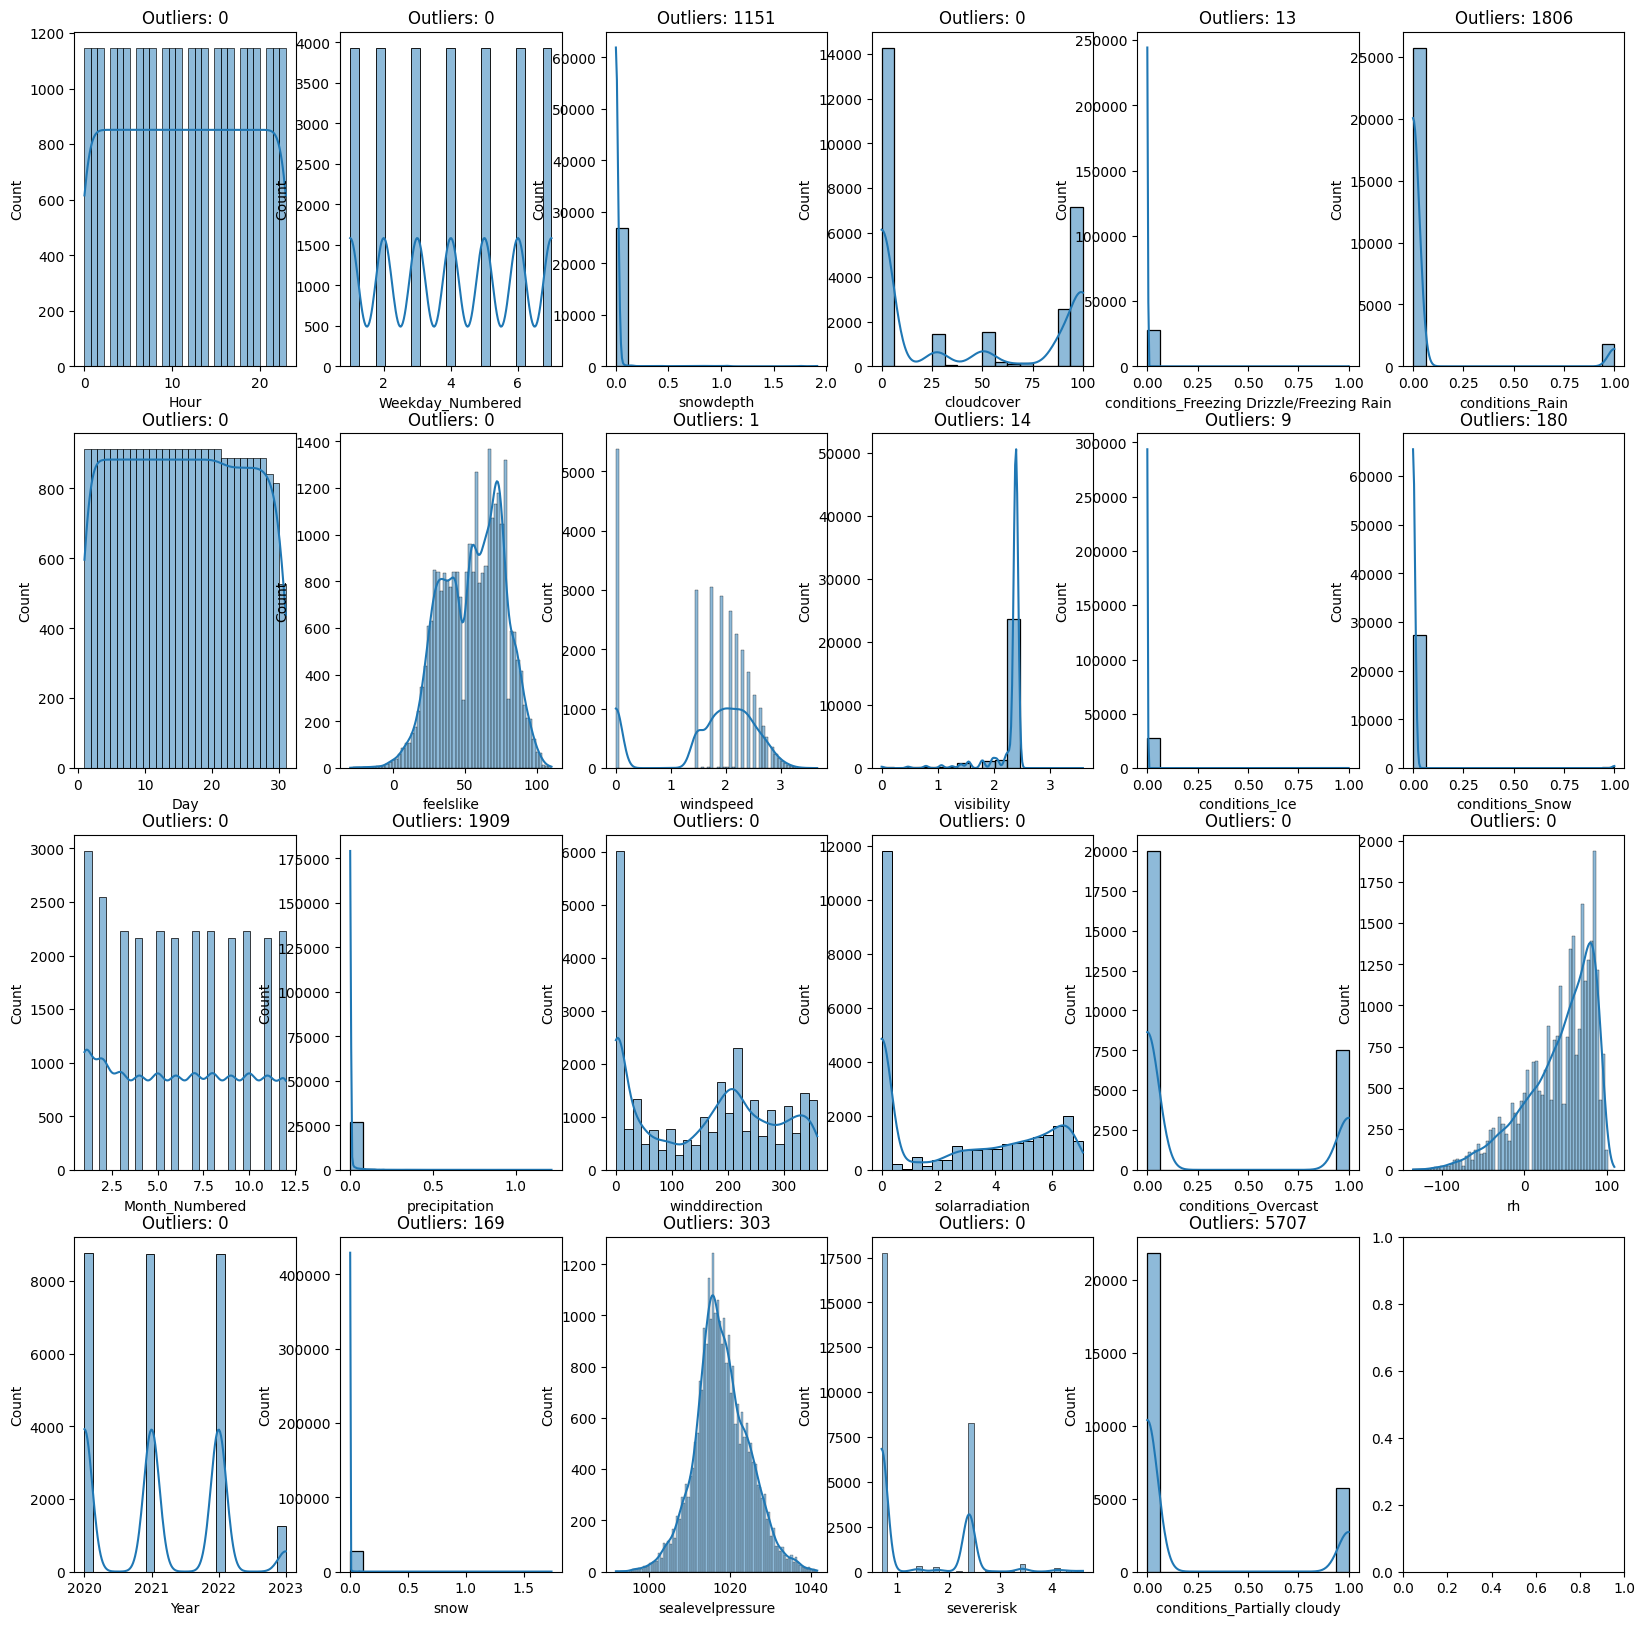

In [ ]:
figure, axes = plt.subplots(4,6, figsize=(20,20)) ;
for i in range(0, len(x.columns)):
    sb.histplot(x=x[x.columns[i]], ax=axes[i%4, int(i/4)], kde=True) ;
    axes[i%4, int(i/4)].set_title(f'Outliers: {countOutliers(x, x.columns[i])}') ;

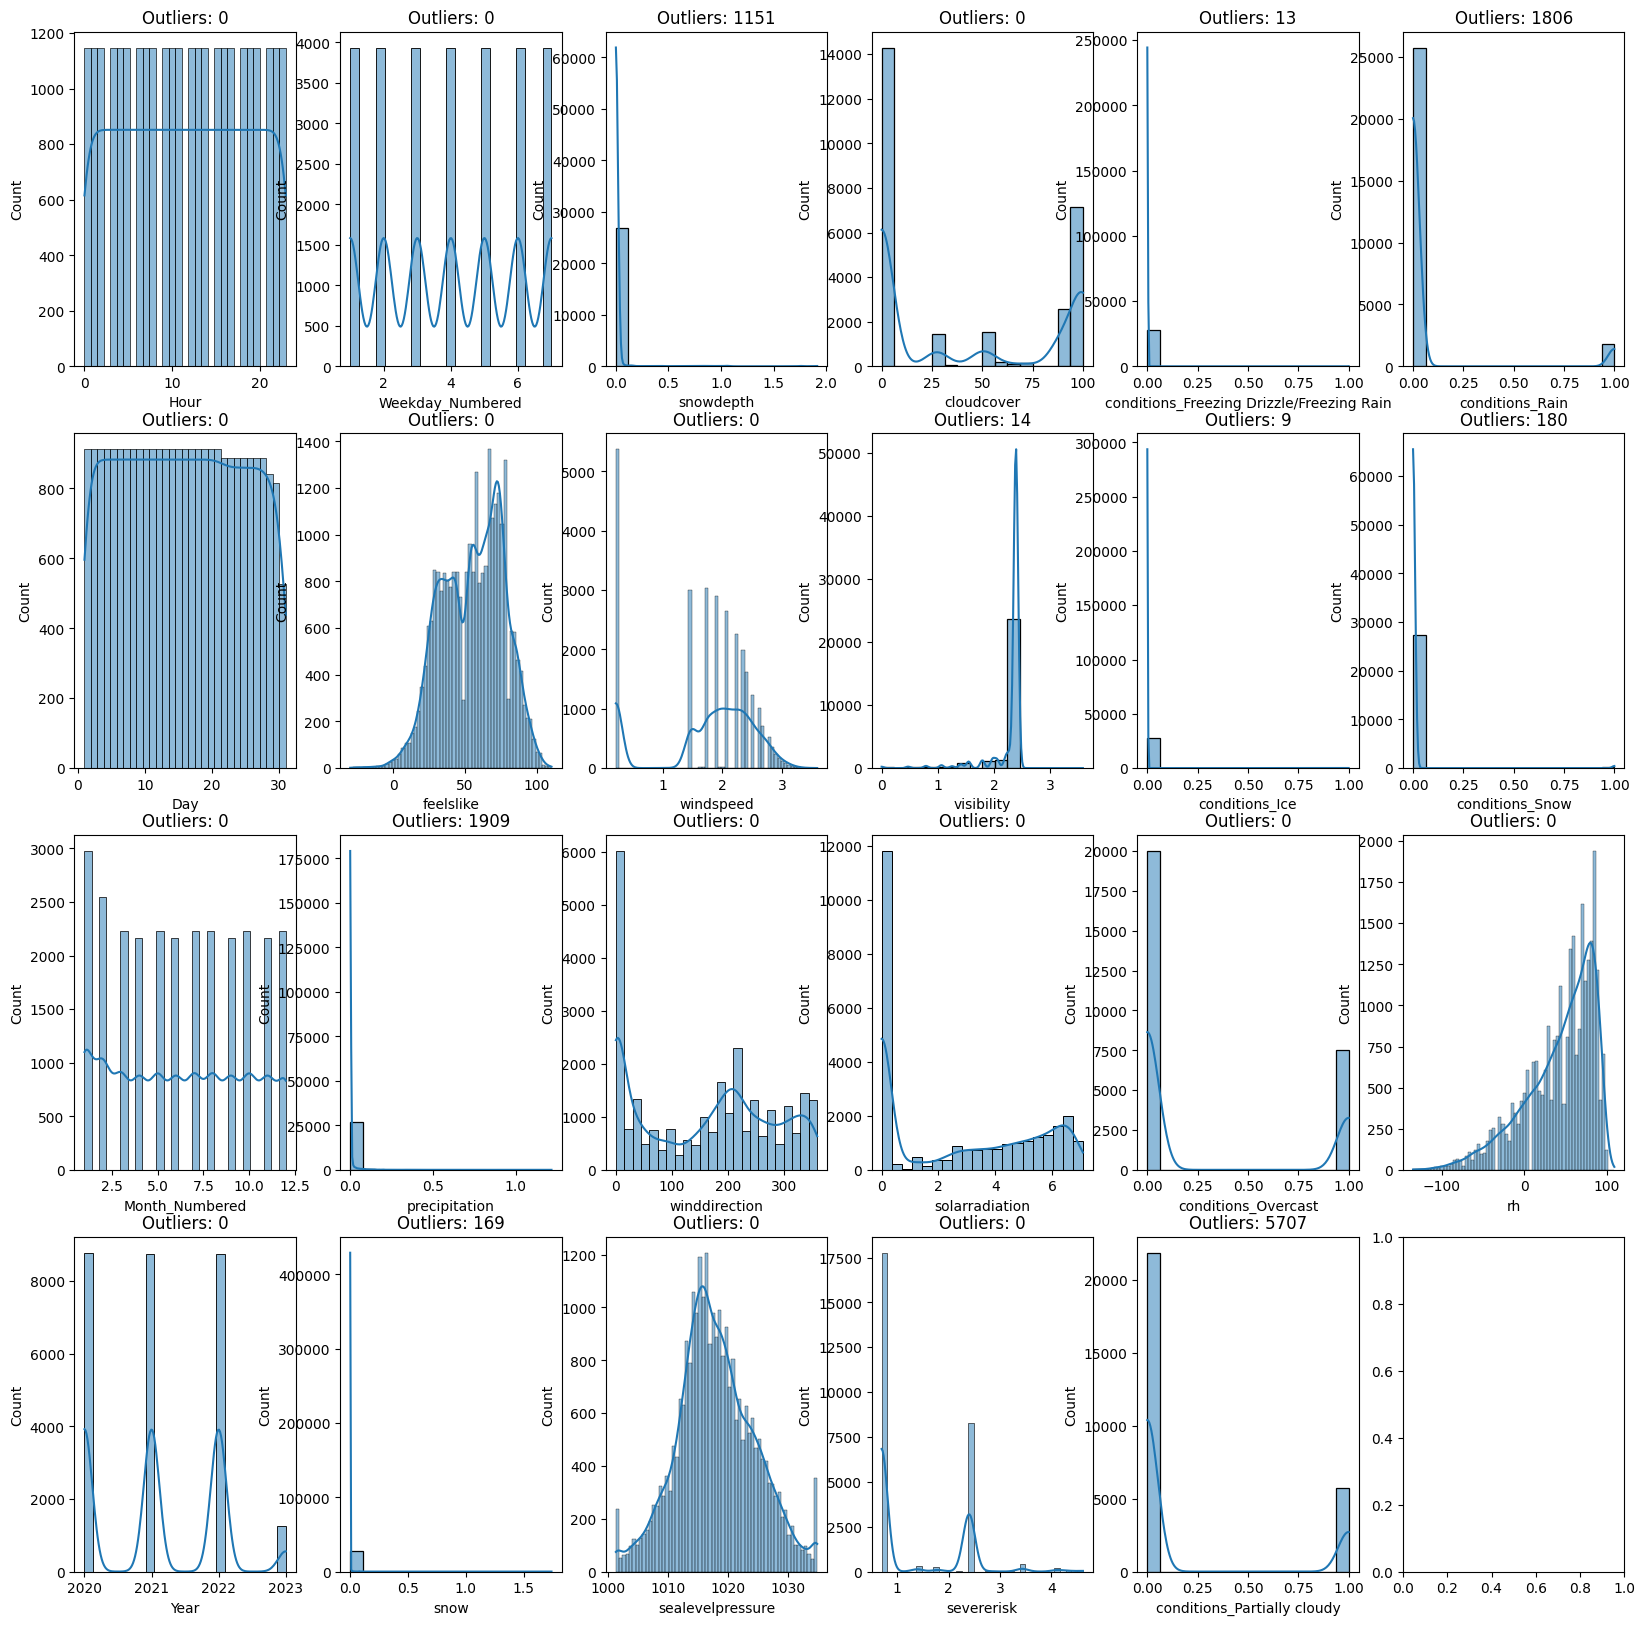

In [ ]:
for i in x.columns:
    if i in ['windspeed', 'sealevelpressure']:
        x[i] = capOutliers(x, i) ;

figure, axes = plt.subplots(4,6, figsize=(20,20)) ;
for i in range(0, len(x.columns)):
    sb.histplot(x=x[x.columns[i]], ax=axes[i%4, int(i/4)], kde=True) ;
    axes[i%4, int(i/4)].set_title(f'Outliers: {countOutliers(x, x.columns[i])}') ;

In [ ]:
from sklearn.model_selection import train_test_split ;
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, shuffle=False) ;
xtrain.shape

(22041, 23)

In [ ]:
from sklearn.preprocessing import StandardScaler ;
sc = StandardScaler() ;
xtrain = pd.DataFrame(sc.fit_transform(xtrain), columns=x.columns) ;
xtrain.head()

,Hour,Day,Month_Numbered,Year,Weekday_Numbered,feelslike,precipitation,snow,snowdepth,windspeed,...,visibility,solarradiation,severerisk,conditions_Freezing Drizzle/Freezing Rain,conditions_Ice,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,conditions_Snow,rh
0,-1.660776,-1.658943,-1.454391,-1.071878,-0.499762,-0.995067,-0.152553,-0.031372,-0.129092,-0.019959,...,0.329589,-1.04483,-0.469613,-0.024293,-0.020211,1.634897,-0.517370,-0.267222,-0.077324,0.300247
1,-1.516323,-1.658943,-1.454391,-1.071878,-0.499762,-0.995067,-0.152553,-0.031372,-0.129092,-0.019959,...,0.329589,-1.04483,-0.469613,-0.024293,-0.020211,1.634897,-0.517370,-0.267222,-0.077324,0.408809
2,-1.371869,-1.658943,-1.454391,-1.071878,-0.499762,-0.934376,-0.152553,-0.031372,-0.129092,-0.329600,...,0.329589,-1.04483,-0.469613,-0.024293,-0.020211,1.634897,-0.517370,-0.267222,-0.077324,0.517370
3,-1.227415,-1.658943,-1.454391,-1.071878,-0.499762,-1.041752,-0.152553,-0.031372,-0.129092,-0.019959,...,0.329589,-1.04483,-0.469613,-0.024293,-0.020211,-0.611659,1.932854,-0.267222,-0.077324,0.517370
4,-1.082961,-1.658943,-1.454391,-1.071878,-0.499762,-1.093106,-0.152553,-0.031372,-0.129092,-0.329600,...,0.329589,-1.04483,-0.469613,-0.024293,-0.020211,-0.611659,-0.517370,-0.267222,-0.077324,0.650056


## Model Training

1. Support Vector Regressor (SVR)

In [ ]:
from sklearn.svm import SVR ;
grid = {
    'kernel': ['linear', 'poly' , 'rbf'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.001, 0.01, 0.1],
    'gamma': ['auto', 0.01, 0.1]
}

In [ ]:
#gs = GridSearchCV(SVR(), grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error') ;
#model = gs.fit(xtrain, ytrain) ;
#print(model.best_params_) ;

No need to keep doing it after once !
- hyperparameters = {'C': 100, 'epsilon': 0.1, 'gamma': '0.01', 'kernel': 'rbf'}

In [ ]:
svr_hp = {'C': 100, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'} ;
svr = SVR(**svr_hp) ;
#svr = SVR(**model.best_params_) ;
svr.fit(xtrain, ytrain)

SVR(C=100, gamma=0.01)

2. Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor ;
gridDepth = np.arange(6,10) ;
gridMinSamples = np.arange(2,10) ;
gridMaxLeaves = np.arange(6,10) ;
rf_grid = {
                'n_estimators' : [100, 200, 500],
                'max_depth': gridDepth,
                'min_samples_leaf': gridMinSamples,
                'max_leaf_nodes': gridMaxLeaves
          } ;

In [ ]:
#gsrf = GridSearchCV(RandomForestRegressor(), rf_grid, n_jobs=-1, verbose=2, cv=5, scoring='neg_mean_absolute_error') ;
#model = gsrf.fit(xtrain, ytrain) ;
#print(model.best_params_) ;

No need to keep doing it after once !
- hyperparameters = {'max_depth': 9, 'max_leaf_nodes': 9, 'min_samples_leaf': 7, 'n_estimators': 200}

In [ ]:
rf_hp = {'max_depth': 9, 'n_estimators': 200, 'min_samples_leaf': 7} ;
rf = RandomForestRegressor(**rf_hp) ;
#rf = RandomForestRegressor(**model.best_params_) ;
rf.fit(xtrain, ytrain)

RandomForestRegressor(max_depth=9, min_samples_leaf=7, n_estimators=200)

In [ ]:
def plotFeatureImportances(model, xtrain):
  feature_importances = model.feature_importances_ ;
  indices = np.argsort(feature_importances)[::-1] ;
  feature_names = [f'{xtrain.columns[i]}' for i in indices] ;
  plt.figure(figsize=(8, 6)) ;
  plt.bar(range(xtrain.shape[1]), feature_importances[indices]) ;
  plt.xticks(range(xtrain.shape[1]), feature_names, rotation=90) ;
  plt.title("Feature Importances") ;
  plt.xlabel("Features") ;
  plt.ylabel("Importance") ;
  plt.show()

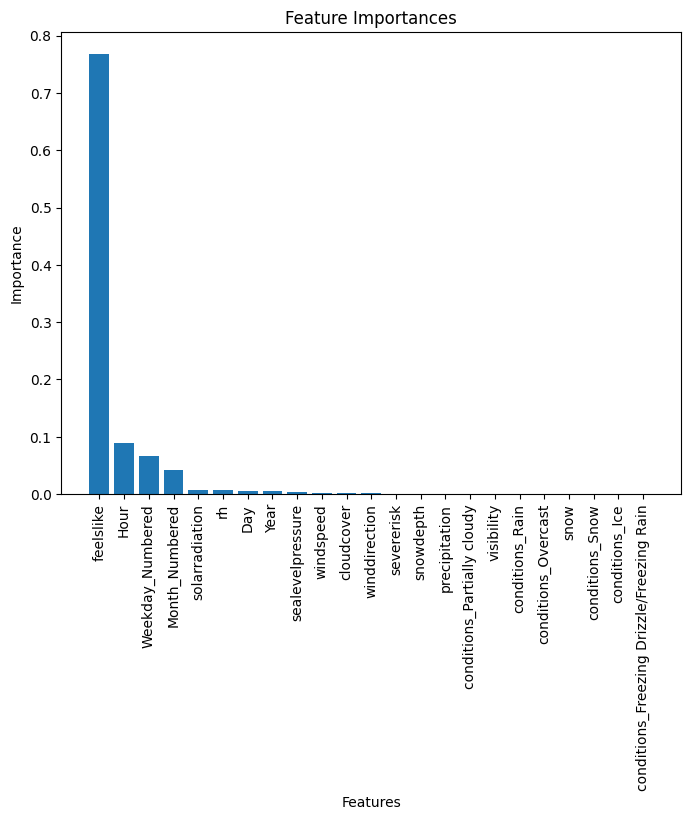

In [ ]:
plotFeatureImportances(rf, xtrain) ;

3. XGB Regressor


In [ ]:
from xgboost import XGBRegressor ;
xgb_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [500],
    'max_depth': [3, 5, 7],
    'gamma': [0, 1, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 1, 5],
    'reg_lambda': [0, 1, 5]
} ;

In [ ]:
#gsxgb = GridSearchCV(XGBRegressor(), xgb_grid, n_jobs=-1, verbose=2, cv=3, scoring='neg_mean_absolute_error') ;
#model = gsxgb.fit(xtrain, ytrain) ;
#print(model.best_params_) ;

No need to keep doing it after once !

  - hyperparameters = { 'colsample_bytree': 0.8, 'gamma': 2, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample': 1.0}



In [ ]:
xgb_hp =  {'colsample_bytree': 0.8, 'gamma': 2, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample': 1.0} ;
xgb = XGBRegressor(**xgb_hp) ;
#xgb = XGBRegressor(**model.best_params_) ;
xgb.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

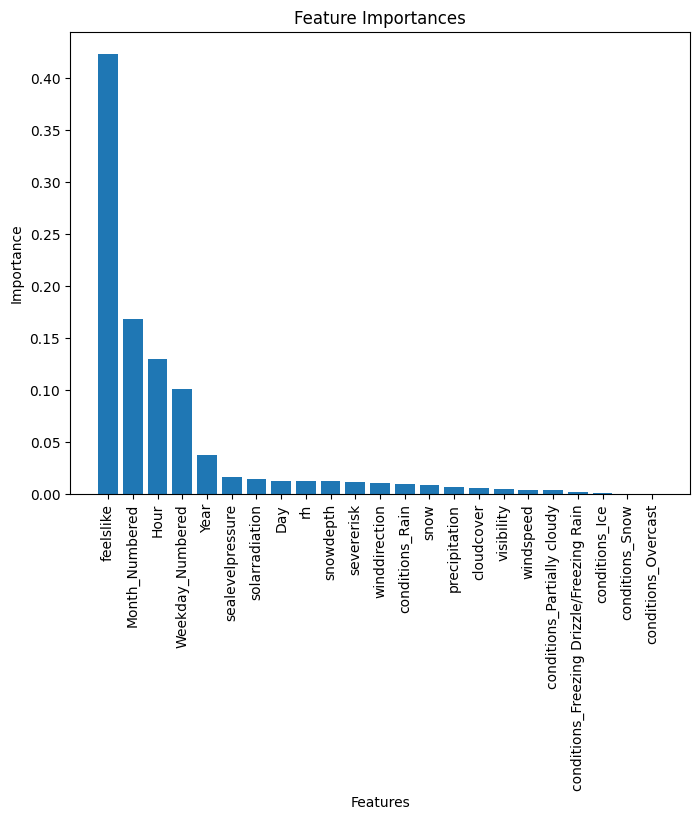

In [ ]:
plotFeatureImportances(xgb, xtrain) ;

Using model on validation data

In [ ]:
test = pd.DataFrame(sc.transform(xtest), columns=xtest.columns) ;
test

,Hour,Day,Month_Numbered,Year,Weekday_Numbered,feelslike,precipitation,snow,snowdepth,windspeed,...,visibility,solarradiation,severerisk,conditions_Freezing Drizzle/Freezing Rain,conditions_Ice,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,conditions_Snow,rh
0,-0.360692,-0.978504,0.315791,1.589523,0.000545,1.091763,0.984606,-0.031372,-0.129092,-1.838168,...,0.329589,0.776426,3.258860,-0.024293,-0.020211,-0.611659,1.932854,3.742203,-0.077324,0.770679
1,-0.216238,-0.978504,0.315791,1.589523,0.000545,1.091763,-0.004309,-0.031372,-0.129092,-0.019959,...,-1.690171,0.915572,3.258860,-0.024293,-0.020211,-0.611659,1.932854,3.742203,-0.077324,0.770679
2,-0.071785,-0.978504,0.315791,1.589523,0.000545,1.091763,1.997026,-0.031372,-0.129092,-0.329600,...,0.329589,1.168254,4.179656,-0.024293,-0.020211,-0.611659,1.932854,3.742203,-0.077324,0.662118
3,0.072669,-0.978504,0.315791,1.589523,0.000545,1.469914,-0.152553,-0.031372,-0.129092,0.539615,...,0.329589,0.755517,4.179656,-0.024293,-0.020211,-0.611659,1.932854,-0.267222,-0.077324,0.758617
4,0.217123,-0.978504,0.315791,1.589523,0.000545,1.049747,-0.152553,-0.031372,-0.129092,0.798618,...,0.329589,0.755517,4.179656,-0.024293,-0.020211,-0.611659,1.932854,-0.267222,-0.077324,0.770679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5506,1.083846,0.609188,-1.159361,2.920223,-1.000068,-0.294788,-0.152553,-0.031372,-0.129092,-0.329600,...,0.329589,-1.044830,1.849423,-0.024293,-0.020211,-0.611659,1.932854,-0.267222,-0.077324,-1.147235
5507,1.228300,0.609188,-1.159361,2.920223,-1.000068,-0.294788,-0.152553,-0.031372,-0.129092,-0.329600,...,0.329589,-1.044830,1.849423,-0.024293,-0.020211,-0.611659,1.932854,-0.267222,-0.077324,-1.255796
5508,1.372754,0.609188,-1.159361,2.920223,-1.000068,-0.122053,-0.152553,-0.031372,-0.129092,0.191111,...,0.329589,-1.044830,1.849423,-0.024293,-0.020211,1.634897,-0.517370,-0.267222,-0.077324,-1.870976
5509,1.517207,0.609188,-1.159361,2.920223,-1.000068,-0.122053,-0.152553,-0.031372,-0.129092,0.191111,...,0.329589,-1.044830,1.849423,-0.024293,-0.020211,1.634897,-0.517370,-0.267222,-0.077324,-1.629729


In [ ]:
def plotValidationPrediction(model, test, ytest, title):
  # Prediction Plot
  validations = model.predict(test) ;
  validations = pd.DataFrame(index=xtest.index, data=validations, columns=['Predicted Demand (MW)']) ;
  plt.figure(figsize=(10,5)) ;
  ytest.plot(label='Actual Demand (MW)') ;
  validations['Predicted Demand (MW)'].plot(label='Predicted Demand') ;
  plt.legend() ;
  plt.title(title) ;
  # Metrics
  n = test.shape[0]  # Number of observations
  p = test.shape[1]  # Number of features (including the intercept)
  adjusted_r2_score = 1 - (1 - r2_score(ytest, validations)) * (n - 1) / (n - p - 1) ;
  print('--'*50) ;
  print('Goodness of fit: ', r2_score(ytrain, model.predict(xtrain))) ;
  print('MAE: ', mean_absolute_error(ytest, validations)) ;
  print('R2 Score: ', r2_score(ytest, validations)) ;
  print('Adjusted R2 Score: ', adjusted_r2_score) ;
  print('--'*50) ;

----------------------------------------------------------------------------------------------------
Goodness of fit:  0.8293322389794553
MAE:  41.95380265985056
R2 Score:  0.784834637933919
Adjusted R2 Score:  0.7839327237134853
----------------------------------------------------------------------------------------------------


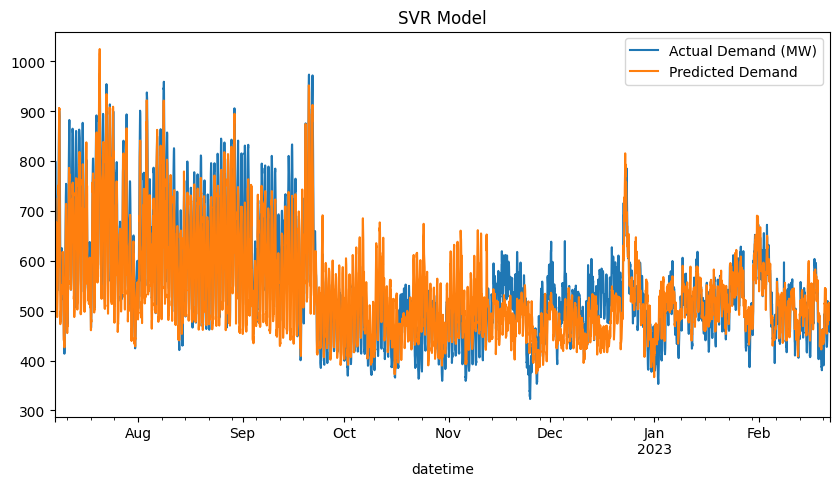

In [ ]:
plotValidationPrediction(svr, test, ytest, 'SVR Model') ;

----------------------------------------------------------------------------------------------------
Goodness of fit:  0.9119001184491136
MAE:  31.996864968887966
R2 Score:  0.8612281137137136
Adjusted R2 Score:  0.8606464200041118
----------------------------------------------------------------------------------------------------


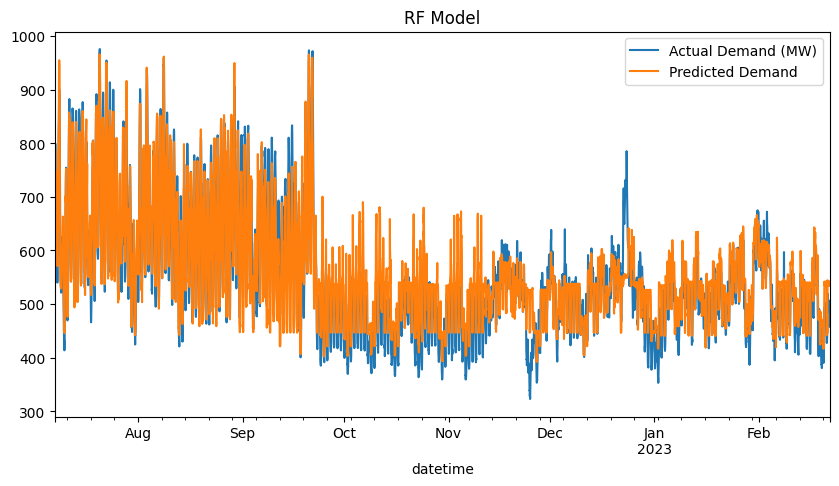

In [ ]:
plotValidationPrediction(rf, test, ytest, 'RF Model') ;

----------------------------------------------------------------------------------------------------
Goodness of fit:  0.9362074544768526
MAE:  31.620498717586134
R2 Score:  0.8765211062328302
Adjusted R2 Score:  0.8760035165560223
----------------------------------------------------------------------------------------------------


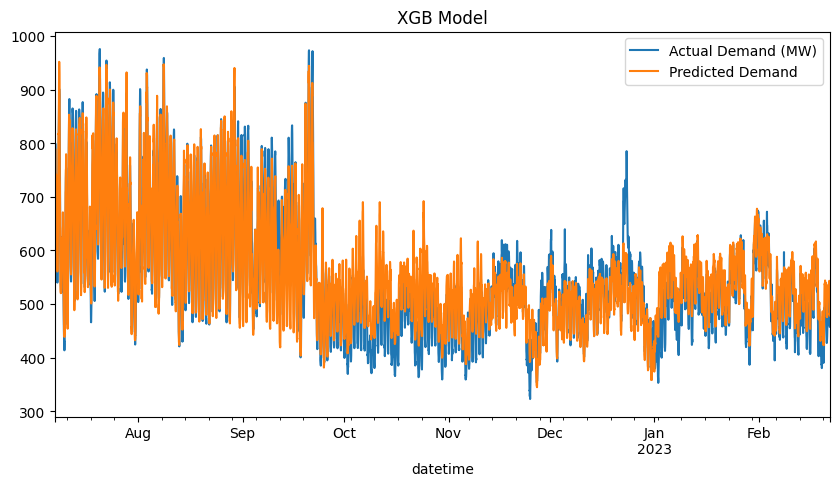

In [ ]:
plotValidationPrediction(xgb, test, ytest, 'XGB Model') ;

Using model on test data

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Demand Forecasting Weather Data upto Feb 28.csv') ;
test.index = pd.to_datetime(test['datetime']) ;
test = test.sort_index() ;
test['conditions'] = test['conditions'].str.split(', ') ;
test = test.explode('conditions') ;
test = pd.get_dummies(test, columns=['conditions'], drop_first=False, dtype='int') ;
test = test.groupby(level=0).max() ;
test['rh'] = 100 - 5*(test['Temperature']-test['dewpoint']) ;
test = test[test.index > "2023-02-22 00:00:00"] ;
test = test.drop(weather_dropped_columns, axis=1) ;
test = test.ffill() ;
test

,Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,snow,snowdepth,windspeed,winddirection,...,uvindex,severerisk,conditions_Clear,conditions_Freezing Drizzle/Freezing Rain,conditions_Ice,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,conditions_Snow,rh
datetime,,,,,,,,,,,,,,,,,,,,,
2023-02-22 01:00:00,56.9,56.9,35.1,43.72,0.0,0,0.0,0.0,6.9,140.0,...,0,10.0,0,0,0,1,0,0,0,-9.0
2023-02-22 02:00:00,56.9,56.9,38.0,49.13,0.0,0,0.0,0.0,4.7,130.0,...,0,10.0,1,0,0,0,0,0,0,5.5
2023-02-22 03:00:00,57.8,57.8,41.0,53.38,0.0,0,0.0,0.0,8.1,160.0,...,0,10.0,1,0,0,0,0,0,0,16.0
2023-02-22 04:00:00,57.8,57.8,46.1,64.98,0.0,0,0.0,0.0,11.4,170.0,...,0,10.0,0,0,0,1,0,0,0,41.5
2023-02-22 05:00:00,60.2,60.2,52.1,74.59,0.0,0,0.0,0.0,11.4,190.0,...,0,10.0,0,0,0,0,1,0,0,59.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 19:00:00,56.0,56.0,39.8,54.45,0.0,0,0.0,0.0,0.0,0.0,...,0,10.0,1,0,0,0,0,0,0,19.0
2023-02-28 20:00:00,52.1,52.1,41.0,65.83,0.0,0,0.0,0.0,3.4,70.0,...,0,10.0,1,0,0,0,0,0,0,44.5
2023-02-28 21:00:00,53.1,53.1,41.0,63.45,0.0,0,0.0,0.0,3.4,70.0,...,0,10.0,1,0,0,0,0,0,0,39.5


In [ ]:
testPrefix = pd.DataFrame(test.index) ;
testPrefix = populateWithTimeFeatures(testPrefix, 'datetime') ;
testPrefix['Weekday_Numbered'] = testPrefix['Weekday'].map(weeks) ;
testPrefix = testPrefix.drop(['datetime'], axis=1) ;
testPrefix

,Hour,Day,Quarter,Month_Numbered,Month,Year,Week,Weekday,Weekday_Numbered
datetime,,,,,,,,,
2023-02-22 01:00:00,1,22,1,2,February,2023,8,Wednesday,3
2023-02-22 02:00:00,2,22,1,2,February,2023,8,Wednesday,3
2023-02-22 03:00:00,3,22,1,2,February,2023,8,Wednesday,3
2023-02-22 04:00:00,4,22,1,2,February,2023,8,Wednesday,3
2023-02-22 05:00:00,5,22,1,2,February,2023,8,Wednesday,3
...,...,...,...,...,...,...,...,...,...
2023-02-28 19:00:00,19,28,1,2,February,2023,9,Tuesday,2
2023-02-28 20:00:00,20,28,1,2,February,2023,9,Tuesday,2
2023-02-28 21:00:00,21,28,1,2,February,2023,9,Tuesday,2


In [ ]:
test = pd.concat([testPrefix, test], axis=1) ;
test = test.drop(dropped_columns+['humidity'], axis=1) ;
for i in log_needed_features:
  test[i] = ft.transform(test[i]) ;
test = pd.DataFrame(sc.transform(test), index = test.index, columns=test.columns) ;
test

,Hour,Day,Month_Numbered,Year,Weekday_Numbered,feelslike,precipitation,snow,snowdepth,windspeed,...,visibility,solarradiation,severerisk,conditions_Freezing Drizzle/Freezing Rain,conditions_Ice,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,conditions_Snow,rh
datetime,,,,,,,,,,,,,,,,,,,,,
2023-02-22 01:00:00,-1.516323,0.722594,-1.159361,2.920223,-0.499762,0.055351,-0.152553,-0.031372,-0.129092,0.370464,...,0.329589,-1.04483,1.849423,-0.024293,-0.020211,1.634897,-0.517370,-0.267222,-0.077324,-1.243733
2023-02-22 02:00:00,-1.371869,0.722594,-1.159361,2.920223,-0.499762,0.055351,-0.152553,-0.031372,-0.129092,-0.019959,...,0.329589,-1.04483,1.849423,-0.024293,-0.020211,-0.611659,-0.517370,-0.267222,-0.077324,-0.893925
2023-02-22 03:00:00,-1.227415,0.722594,-1.159361,2.920223,-0.499762,0.097368,-0.152553,-0.031372,-0.129092,0.539615,...,0.329589,-1.04483,1.849423,-0.024293,-0.020211,-0.611659,-0.517370,-0.267222,-0.077324,-0.640616
2023-02-22 04:00:00,-1.082961,0.722594,-1.159361,2.920223,-0.499762,0.097368,-0.152553,-0.031372,-0.129092,0.909734,...,0.329589,-1.04483,1.849423,-0.024293,-0.020211,1.634897,-0.517370,-0.267222,-0.077324,-0.025436
2023-02-22 05:00:00,-0.938507,0.722594,-1.159361,2.920223,-0.499762,0.209412,-0.152553,-0.031372,-0.129092,0.909734,...,0.329589,-1.04483,1.849423,-0.024293,-0.020211,-0.611659,1.932854,-0.267222,-0.077324,0.408809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 19:00:00,1.083846,1.403034,-1.159361,2.920223,-1.000068,0.013334,-0.152553,-0.031372,-0.129092,-2.101838,...,0.329589,-1.04483,1.849423,-0.024293,-0.020211,-0.611659,-0.517370,-0.267222,-0.077324,-0.568242
2023-02-28 20:00:00,1.228300,1.403034,-1.159361,2.920223,-1.000068,-0.168738,-0.152553,-0.031372,-0.129092,-0.329600,...,0.329589,-1.04483,1.849423,-0.024293,-0.020211,-0.611659,-0.517370,-0.267222,-0.077324,0.046938
2023-02-28 21:00:00,1.372754,1.403034,-1.159361,2.920223,-1.000068,-0.122053,-0.152553,-0.031372,-0.129092,-0.329600,...,0.329589,-1.04483,1.849423,-0.024293,-0.020211,-0.611659,-0.517370,-0.267222,-0.077324,-0.073685


Demand Forecasting

In [ ]:
prevData = pd.read_csv('/content/drive/MyDrive/Demand Forecasting Demand Data upto Feb 21.csv') ;
prevData['datetime'] = pd.to_datetime(prevData['datetime']) ;
prevData = prevData[prevData['datetime'] > "2023-01-31 23:00:00"]  ;
prevData.index = pd.to_datetime(prevData['datetime']) ;
prevData = prevData.drop('datetime', axis=1) ;
prevData

,Demand (MW)
datetime,
2023-02-01 00:00:00,611.9
2023-02-01 01:00:00,575.1
2023-02-01 02:00:00,575.5
2023-02-01 03:00:00,582.4
2023-02-01 04:00:00,586.0
...,...
2023-02-21 19:00:00,498.7
2023-02-21 20:00:00,498.8
2023-02-21 21:00:00,506.4


In [ ]:
def forecast(model, test, title, threshold=540, show=False):
  plt.figure(figsize=(12, 6)) ;
  predictions = model.predict(test) ;
  predictions = pd.DataFrame(index=test.index, data=predictions, columns=['Predicted Demand (MW)']) ;
  predictions.to_csv(f'/content/drive/MyDrive/{title}.csv') ;
  prevData['Demand (MW)'].plot(label= 'Demand (MW)')
  predictions['Predicted Demand (MW)'].plot(label= 'Forecasted Demand (MW)') ;
  if(show): plt.axhline(threshold, linestyle='--', color='red', label='Over budget threshold') ;
  plt.title(title) ;
  plt.xticks(rotation=90) ;
  plt.legend() ;
  return predictions ;

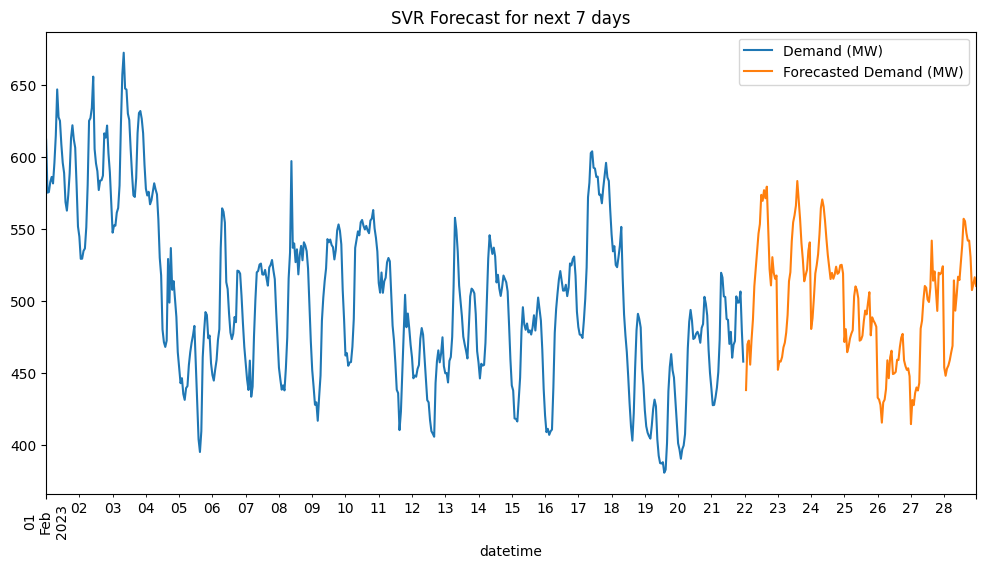

In [ ]:
svr_predictions = forecast(svr, test, 'SVR Forecast for next 7 days') ;

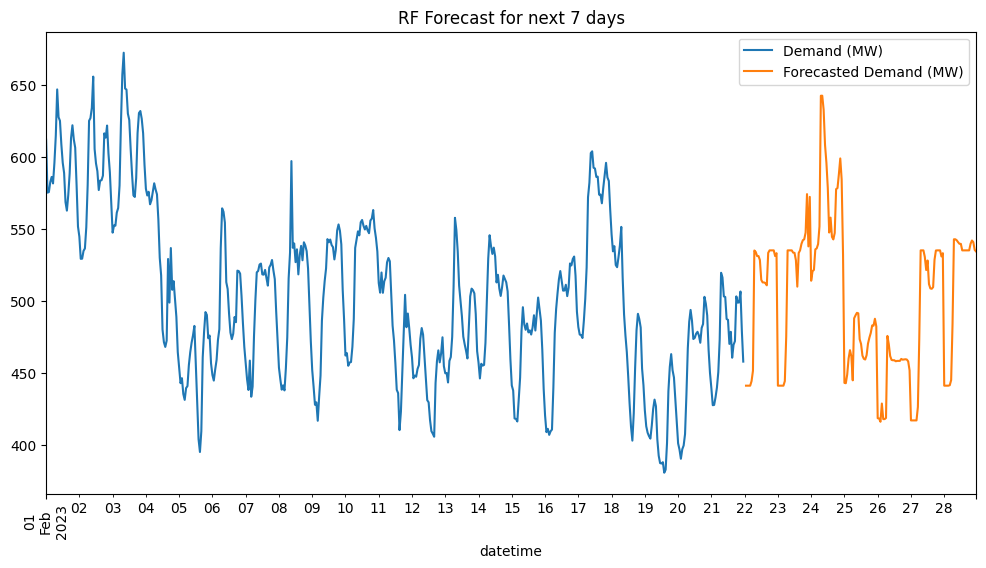

In [ ]:
rf_predictions = forecast(rf, test, 'RF Forecast for next 7 days') ;

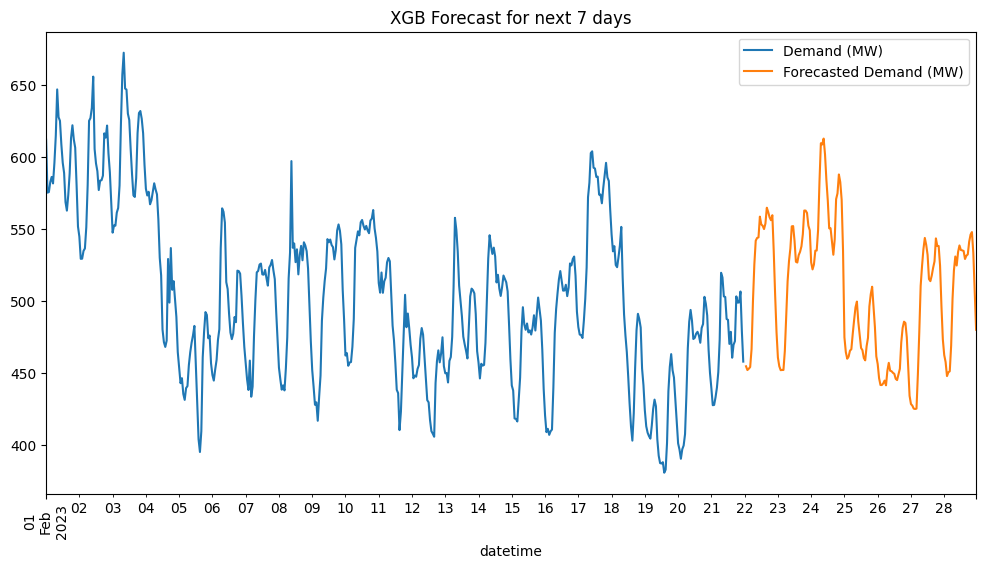

In [ ]:
xgb_predictions = forecast(xgb, test, 'XGB Forecast for next 7 days') ;

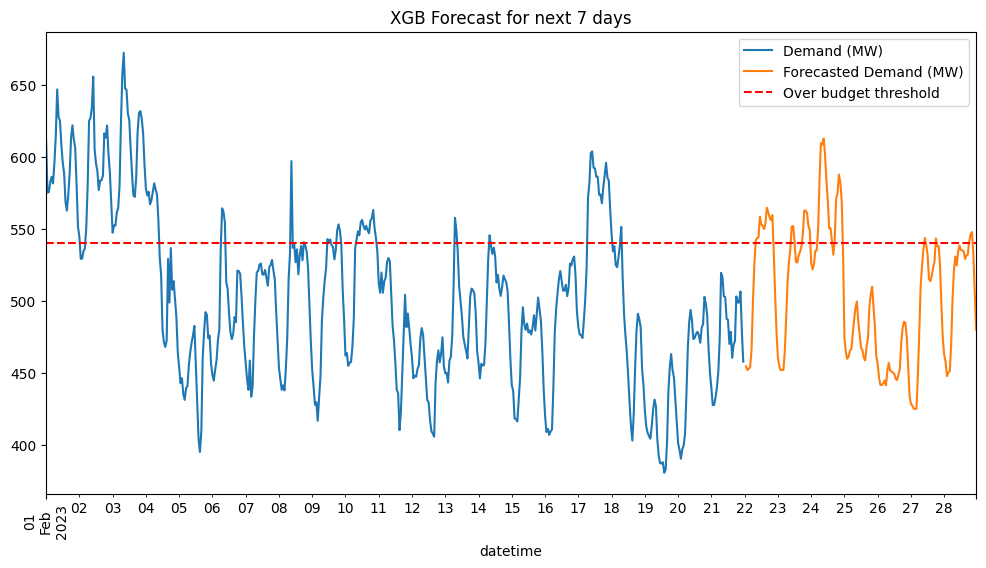

In [ ]:
xgb_predictions = forecast(xgb, test, 'XGB Forecast for next 7 days', show=True) ;